In [482]:
# %load imports.py
%load_ext autoreload
%autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [483]:
import brian2 as br
from brian2.units import *
import numpy as np

In [484]:
import warnings 
def set_parameters_from_dict(neurongroup, dictionary_of_parameters):
    for param_key, param_value in dictionary_of_parameters.items():
        try: 
            neurongroup.__setattr__(param_key, param_value)
        except AttributeError as err:
            warnings.warn("{:s} has no paramater {:s}".format(neurongroup.name, param_key))

# Definition of the Neuron and Synapse Model

In [485]:
import sys
import os
cwd = os.getcwd()
sys.path.append('/home/drangmeister/projects/grid_cell_model_with_reciprocal_ie_connectivity/grid_cell_model')
from default_params import defaultParameters as no

y_dim       = np.sqrt(3)/2.

for key, value in no.items():
    try:
        exec("%s=%f" % (key, value))
    except:
        warnings.warn('This is highly terrible and does not convert strings to variables')
tau1_GABA = tau_GABA_A_fall
tau2_GABA = tau_GABA_A_rise * tau_GABA_A_fall / \
        (tau_GABA_A_rise + tau_GABA_A_fall)
B_GABA = 1./((tau2_GABA/tau1_GABA)**(tau_GABA_A_rise/tau1_GABA) - 
        (tau2_GABA/tau1_GABA)**(tau_GABA_A_rise/tau2_GABA))
model_eqs = '''
            dvm/dt      = 1/C*Im + (noise_sigma*xi/taum_mean**.5)                      : volt (unless refractory)
            Ispike      = gL*deltaT*exp((vm-Vt)/deltaT)                                : amp
            Im          = gL*(EL-vm) + g_ahp*(Eahp - vm) + Ispike + Isyn + Iext        : amp
            Isyn        = B_GABA*(gi1 - gi2)*(Esyn_i - vm) + ge*(Esyn_e - vm) + gNMDA*(Esyn_e - vm) : amp
            dge/dt      = -ge/syn_tau_e                                                : siemens
            dgNMDA/dt   = -gNMDA/tau_NMDA_fall                                         : siemens
            dgi1/dt     = -gi1/syn_tau1                                                : siemens
            dgi2/dt     = -gi2/syn_tau2                                                : siemens
            dg_ahp/dt   = -g_ahp/tau_ahp                                               : siemens
            Iext        = Iext_const                                                   : amp
            EL                                                                         : volt
            taum                                                                       : second
            '''

C             = taum_e * gL_e * pF
gL            = gL_e * nS
noise_sigma   = noise_sigma * mV
deltaT        = deltaT_e * mV
Vt            = Vt_e * mV
Esyn_i        = E_GABA_A * mV
Esyn_e        = E_AMPA * mV
Vclamp        = Vclamp * mV
syn_tau_e     = tau_AMPA * ms
tau_NMDA_fall = tau_NMDA_fall * ms
syn_tau1      = tau1_GABA * ms
syn_tau2      = tau2_GABA * ms
B_GABA        = B_GABA
taum_mean     = taum_e * ms
tau_ahp       = tau_AHP_e * ms
Eahp          = E_AHP_e * mV

EL = EL_e * mV

g_AHP_e = g_AHP_e_max * nS
Vr_e    = Vr_e * mV 
Iext_const = Iext_e_const * pA
# model=eqs_e,
model_threshold= 'vm > V_peak_e * mV'
model_reset="vm=Vr_e; g_ahp=g_AHP_e"
# model_refractory= 0.0 * t_ref_e * msecond
model_refractory= 2.0 * msecond

print(t_ref_e)

gi1_synapse_model = 'gi1_w: siemens'
gi1_synapse = 'gi1+=gi1_w'
# gi1_w = 0.2 * B_GABA * g_GABA_total * nS

gi2_synapse_model = 'gi2_w: siemens'
gi2_synapse = 'gi2+=gi2_w'
pulse_strength = 0.2 * B_GABA * g_GABA_total * nS

print(EL)


WARNING    /home/drangmeister/miniconda3/envs/micro_circuit_notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This is highly terrible and does not convert strings to variables
  del sys.path[0]
 [py.warnings]


10.1
-68.5 mV


## Analysis Functions for the Spike Train

In [486]:
def get_spike_train(delay, pulse_strength, record_state):
    neuron = br.NeuronGroup(N=1, \
                                        name='single_neuron',\
                                        model=model_eqs, \
                                       threshold=model_threshold, \
                                       reset=model_reset,\
                                       refractory = model_refractory)

    neuron.vm       = EL
    neuron.gi1      = 0.0
    neuron.gi2      = 0.0
    neuron.g_ahp    = 0.0

    spike_recorder = br.SpikeMonitor(source=neuron)
    
    gi1_auto_synapse = br.Synapses(source=neuron, target=neuron, model=gi1_synapse_model, on_pre = gi1_synapse, delay = delay)
    gi1_auto_synapse.connect()
    gi1_auto_synapse.gi1_w = pulse_strength
    
    gi2_auto_synapse = br.Synapses(source=neuron, target=neuron, model=gi2_synapse_model, on_pre = gi2_synapse, delay = delay)
    gi2_auto_synapse.connect()
    gi2_auto_synapse.gi2_w = pulse_strength
    
    net = br.Network(neuron)
    net.add(gi1_auto_synapse)
    net.add(gi2_auto_synapse)
    net.add(spike_recorder)
    
    if record_state:
        state_recorder = br.StateMonitor(neuron,'vm',record=True)
        net.add(state_recorder)
        net.run(duration=duration, report='stdout')
    
        spike_train = spike_recorder.spike_trains()
        return spike_train, np.array([state_recorder.t,state_recorder.vm[0]])
    else:
        net.run(duration=duration)

        spike_train = spike_recorder.spike_trains()
        return spike_train


In [487]:
def get_mean_period(spike_train):
    return (np.max(spike_train[0]) - np.min(spike_train[0])) / (spike_train[0].shape[0] - 1)

In [488]:
def get_mean_response(spike_trains_dict,t_isi):
    mean_response_dict = {}
#     t_isi = get_mean_period(spike_trains_dict[0.0 * ms])
    for delay, spike_train in spike_trains_dict.items():
        mean_response_dict[delay] = get_mean_period(spike_train) - t_isi
    return mean_response_dict

## Plotting Functions

In [489]:
import matplotlib.pyplot as plt

In [490]:
def plot_spiking(spike_trains_dict):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for key, times in spike_trains_dict.items():
        ax.plot(times[0]/ms, key*np.ones(times[0].shape), 'b.')
#     ax.plot(spike_train[0]/ms, np.ones(spike_train[0].shape), 'b|')

    ax.grid(axis='x')
#     ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel("Time(ms)");

In [491]:
def plot_mean_period(mean_period_dict):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(list(mean_period_dict.keys()), list(mean_period_dict.values()), 'b')

    ax.grid(axis='x')
    ax.set_xlabel("Delay (ms)");

In [492]:
def plot_mean_response(mean_response_dict):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(list(mean_response_dict.keys()), list(mean_response_dict.values()), 'b')

    ax.grid(axis='x')
    ax.set_xlabel("Delay (ms)");

In [493]:
def plot_state(state):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(state[0], state[1],'r')
    ax.grid(axis='x')
    ax.set_ylim(-0.1,0.0)
    ax.set_xlabel("Time(ms)");

## Execution

In [500]:
duration = 20*ms
n_simulations = 10

spikes_unperturbed, state_unperturbed = get_spike_train(0.0 * ms, 0.0, True)
spikes_perturbed, state_perturbed = get_spike_train(0.0 * ms, pulse_strength, True)


Starting simulation at t=0. s for a duration of 20. ms
0.02 (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 20. ms
0.02 (100%) simulated in < 1s


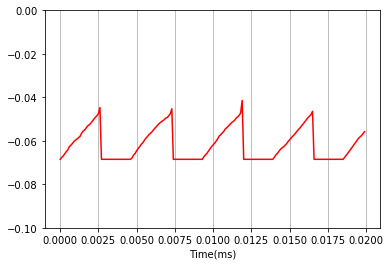

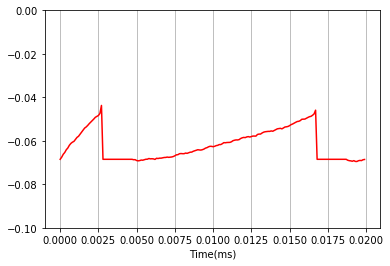

In [501]:
plot_state(state_unperturbed)
plot_state(state_perturbed)


In [496]:
t_isi = get_mean_period(spikes_unperturbed)
print(t_isi)
delay_list = np.linspace(0.0 * ms,t_isi,n_simulations)
spike_trains_dict = {}

for delay in delay_list:
    spike_train = get_spike_train(delay, pulse_strength, False)
    spike_trains_dict[delay/ms] = spike_train

4.53333333 ms


WARNING    /home/drangmeister/miniconda3/envs/micro_circuit_notebooks/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1386: RuntimeWarning: invalid value encountered in true_divide
  result = operation(self_arr, other_arr)
 [py.warnings]


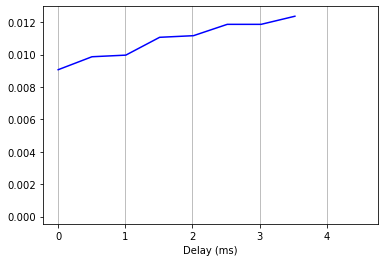

In [497]:
mean_response_dict = get_mean_response(spike_trains_dict, t_isi)
plot_mean_response(mean_response_dict)

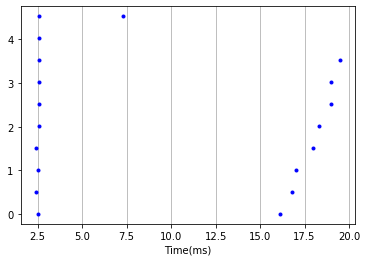

In [498]:
plot_spiking(spike_trains_dict)

In [499]:
# mean_period_dict = {}

# for delay, spike_train in spike_trains_dict.items():
#     mean_period_dict[delay] = get_mean_period(spike_train)

# plot_mean_period(mean_period_dict)